In [188]:
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy.stats import halfnorm, kstest, ks_2samp, wilcoxon, mannwhitneyu, probplot
import pickle
from statsmodels.graphics.gofplots import qqplot_2samples

In [50]:
mars = np.genfromtxt('harp_mars.dat', usecols=np.arange(0, 9))
jupiter = np.genfromtxt('harp_jupiter.dat', usecols=np.arange(0, 8))
uranus = np.genfromtxt('harp_uranus.dat', usecols=np.arange(0, 8))

In [103]:
mars_unc = np.genfromtxt('harp_mars_unc.dat')
jupiter_unc = np.genfromtxt('harp_jupiter_unc.dat')
uranus_unc = np.genfromtxt('harp_uranus_unc.dat')
planets_unc = np.concatenate((mars_unc[:,9], jupiter_unc[:,8], uranus_unc[:,8]), axis=0)

In [109]:
yerr = np.mean(planets_unc[planets_unc!=0])
print(yerr)

0.102780674017


In [51]:
mars_etamb = mars[:,5]
jupiter_etamb = jupiter[:,5]
uranus_etamb = uranus[:,5]

mars_dates = mars[:,0]
jupiter_dates = jupiter[:,0]
uranus_dates = uranus[:,0]

mars = mars[mars[:,1] > 5]
mars = mars[mars[:,1] < 19]
mars = mars[mars[:,5] > 0]
jupiter = jupiter[jupiter[:,1] > 5]
jupiter = jupiter[jupiter[:,1] < 19]
jupiter = jupiter[jupiter[:,5] > 0]
uranus = uranus[uranus[:,1] > 5]
uranus = uranus[uranus[:,1] < 19]
uranus = uranus[uranus[:,5] > 0]

planets_etamb = np.concatenate((mars_etamb, jupiter_etamb, uranus_etamb), axis=0)
raw_dates = np.concatenate((mars_dates, jupiter_dates, uranus_dates), axis=0)
dates = [datetime.datetime.strptime(str(int(date)),'%Y%m%d') for date in raw_dates]

In [52]:
oldest = min(dates)
days = np.array([np.float64((date - oldest).days) + 1 for date in dates])

In [110]:
def draw_samp(x, m, b, yerr_mu, yerr_sig, bias_mu, bias_sig):
    result = []
    yerr = np.random.normal(yerr_mu, yerr_sig, size = len(x))
#     scatter = np.random.normal(scatter_mu, scatter_sig, size = len(x))
    bias = halfnorm.rvs(bias_mu, bias_sig, size = len(x))
#         print(yerr, scatter, bias)
    result = yerr - bias + (m*x + b)
    return np.array(result)

In [182]:
sample = draw_samp(days, 0.0, .61, 0.0, .1, 0.0, .07)
print(sample)

[ 0.56342155  0.52151438  0.62647254  0.59202906  0.40435502  0.67048851
  0.42050767  0.60952113  0.62702347  0.44567761  0.58320097  0.63502566
  0.67558652  0.36681745  0.45662842  0.50711864  0.62737119  0.72366644
  0.60587335  0.80674906  0.50801609  0.68929149  0.57403192  0.358122
  0.72371254  0.51190169  0.59637118  0.59535877  0.53475735  0.39843537
  0.59907842  0.78061422  0.55823122  0.57619345  0.59830783  0.58242076
  0.56469026  0.44579938  0.4871879   0.6059985   0.79283155  0.4209855
  0.49184681  0.58959788  0.65037334  0.44329663  0.5488936   0.5414918
  0.53328204  0.54461077  0.42655694  0.52717476  0.49030752  0.57899531
  0.44814289  0.73566349  0.36075944  0.63277392  0.77503606  0.65600283
  0.42571332  0.47002268  0.60377959  0.46821103  0.54915842  0.49618086
  0.57509652  0.52688794  0.60331536  0.38372568  0.55259218  0.76919679
  0.56151383  0.55283146  0.50699533  0.62930988  0.5081246   0.64346881
  0.64526002  0.54330691  0.73586296  0.54370998  0.518

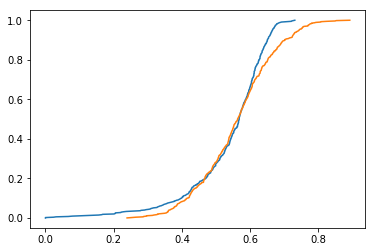

In [186]:
sort_y = np.sort(planets_etamb)
p = np.linspace(0, 1, len(planets_etamb))
data_CDF = lambda x: np.interp(x, sort_y, p)

#plotting CDF of data vs CDF of sample dataset
plt.figure(1)
plt.plot(sort_y, p)
plt.plot(np.sort(sample), p)
plt.show()

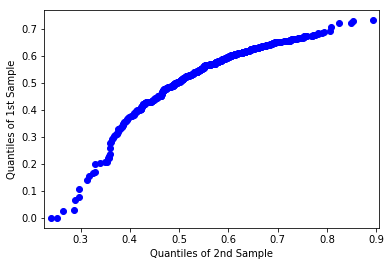

In [189]:
plt.figure(1)
qqplot_2samples(planets_etamb, sample)
plt.show()

In [166]:
# def calc1000kstest(m, b, yerr_mu, yerr_sig, bias_mu, bias_sig):
#     stats = []
#     for i in range(1000):
#         trial = draw_samp(days, m, b, yerr_mu, yerr_sig, bias_mu, bias_sig)
#         stat = ks_2samp(planets_etamb, trial)
#         stats.append(stat[1])
#     return stats, np.mean(stats)

# def calc1000mwu(m, b, yerr_mu, yerr_sig, bias_mu, bias_sig):
#     stats = []
#     for i in range(1000):
#         trial = draw_samp(days, m, b, yerr_mu, yerr_sig, bias_mu, bias_sig)
#         stat = mannwhitneyu(planets_etamb, trial)
#         stats.append(stat[1])
#     return stats, np.mean(stats)

# def calc1000wilcoxon(m, b, yerr_mu, yerr_sig, bias_mu, bias_sig):
#     stats = []
#     for i in range(1000):
#         trial = draw_samp(days, m, b, yerr_mu, yerr_sig, bias_mu, bias_sig)
#         stat = wilcoxon(planets_etamb, trial)
#         stats.append(stat[1])
#     return stats, np.mean(stats)

def calc1000tests(m, b, yerr_mu, yerr_sig, bias_mu, bias_sig):
    ks_stats = [] #each has 1000 p-values, corresponding to one set of params
    mwu_stats = []
    wilcoxon_stats = []
    for i in range(1000):
        trial = draw_samp(days, m, b, yerr_mu, yerr_sig, bias_mu, bias_sig)
        stat = ks_2samp(planets_etamb, trial)
        ks_stats.append(stat[1])
        stat = mannwhitneyu(planets_etamb, trial, alternative = 'two-sided')
        mwu_stats.append(stat[1])
        stat = wilcoxon(planets_etamb, trial)
        wilcoxon_stats.append(stat[1])
        
    return ks_stats, mwu_stats, wilcoxon_stats

In [167]:
test_m = 0.0
test_b = .61
# test_yerr_mu = 0.0
# test_yerr_sig = .005
# test_bias_mu = 0.0
test_bias_sig = .08125
pvals_ks, pvals_mwu, pvals_w = calc1000tests(test_m, test_b, 0.0, 0.1, 0.0, test_bias_sig)
print(pvals_w)

[0.59417403463625684, 0.57414928964427614, 0.051514337771003116, 0.52632055021821977, 0.49605681058325768, 0.83202709747984172, 0.9970122819655578, 0.91649671974972535, 0.99274419639695355, 0.57487846220946359, 0.59158424632615714, 0.67845227322605217, 0.63438868602887954, 0.15106764952254065, 0.087924593166997467, 0.70309750471421983, 0.31753824715068535, 0.32510747434602327, 0.70131220733908617, 0.45487839491729498, 0.33066132497958878, 0.67317267584920426, 0.39042817524611784, 0.28539923102978315, 0.33937685564971865, 0.28891158823297547, 0.89065237062939262, 0.56615744130059054, 0.80148915677047994, 0.74358174782149944, 0.8640823947499352, 0.74135761784859477, 0.55283825797338682, 0.98997004447517323, 0.40475215519839836, 0.27105659814687855, 0.94860404275569754, 0.078462962194949151, 0.94945593606645473, 0.94902998212827994, 0.24203843398384894, 0.35320897719787747, 0.41508587499863048, 0.64817344475362293, 0.98591574214204059, 0.48011559713601748, 0.82785624090353305, 0.682373304

In [168]:
# plt.figure(figsize=(12, 7))
# plt.plot(days, planets_etamb, 'bx')
# plt.plot(days, trial, 'rx')
# plt.xlabel('days')
# plt.ylabel('sampled values')
# plt.show()

In [190]:
num_trials = 5
m = np.linspace(-.001, .001, num=num_trials)
b = np.linspace(.5, .65, num=num_trials)
yerr_sig = np.linspace(0.0, .1, num=num_trials)
bias_sig = np.linspace(0.0, .1, num=num_trials)

In [170]:
a, B, c = np.meshgrid(m, b, bias_sig)
arr = np.stack((np.ravel(a), np.ravel(B), np.ravel(c)), axis=-1)

full_results = {}
# for i in arr:
#     pvals_ks, pvals_mean_ks = calc1000kstest(i[0], i[1], 0.0, yerr, 0.0, i[2])
#     pvals_mwu, pvals_mean_mwu = calc1000mwu(i[0], i[1], 0.0, yerr, 0.0, i[2])
#     pvals_w, pvals_mean_w = calc1000wilcoxon(i[0], i[1], 0.0, yerr, 0.0, i[2])
#     full_results[str(i)] = [[pvals_ks, pvals_mean_ks],[pvals_mwu, pvals_mean_mwu],[pvals_w, pvals_mean_w]]
for i in arr:
    pvals_ks, pvals_mwu, pvals_w = calc1000tests(i[0], i[1], 0.0, yerr, 0.0, i[2]) #each an array of 1000 pvals
    full_results[str(i)] = [pvals_ks, pvals_mwu, pvals_w]

In [ ]:
#version with yerr, consistent new boundaries
d, e, f, g = np.meshgrid(m, b, yerr_sig, bias_sig)
arr2 = np.stack((np.ravel(d), np.ravel(e), np.ravel(f), np.ravel(g)), axis=-1)

full_results_yerr = {}
for i in arr2:
    pvals_ks, pvals_mwu, pvals_w = calc1000tests(i[0], i[1], 0.0, i[2], 0.0, i[3]) #each an array of 1000 pvals
    full_results_yerr[str(i)] = [pvals_ks, pvals_mwu, pvals_w]

In [181]:
#print all test means
for tests in full_results.values():
    print("ks mean: ", np.mean(tests[0]))
    print("mwu mean: ", np.mean(tests[1]))
    print("wilcoxon mean: ", np.mean(tests[2]))

ks mean:  4.34263615235e-171
mwu mean:  2.72430676818e-158
wilcoxon mean:  5.32725789009e-90
ks mean:  1.28255957303e-171
mwu mean:  1.41859421443e-158
wilcoxon mean:  4.99423767274e-90
ks mean:  8.00763753438e-170
mwu mean:  3.7616596648e-157
wilcoxon mean:  4.6143589785e-90
ks mean:  3.47913053669e-171
mwu mean:  1.46336285229e-159
wilcoxon mean:  4.36755204695e-90
ks mean:  2.36662474265e-172
mwu mean:  2.2740816055e-160
wilcoxon mean:  4.01622675236e-90
ks mean:  6.20270270707e-137
mwu mean:  1.51500840113e-137
wilcoxon mean:  2.10415457528e-86
ks mean:  3.37528952421e-137
mwu mean:  8.95718068765e-138
wilcoxon mean:  1.55619426859e-86
ks mean:  1.50987515028e-138
mwu mean:  1.27271541478e-138
wilcoxon mean:  1.21901924533e-86
ks mean:  1.3934646894e-138
mwu mean:  1.03442996043e-139
wilcoxon mean:  9.87169986622e-87
ks mean:  1.21972881669e-139
mwu mean:  5.45683728937e-138
wilcoxon mean:  8.00950642721e-87
ks mean:  0.00383898661271
mwu mean:  0.557721492223
wilcoxon mean:  0.511

In [179]:
#find greatest mean for each test
greatest_ks = -np.inf
greatest_mwu = -np.inf
greatest_w = -np.inf
for params, arr in full_results.items():
    if np.mean(arr[0]) > greatest_ks:
        greatest_ks = np.mean(arr[0])
        greatest_params_ks = params
        p_vals_ks = arr[0]
    if np.mean(arr[1]) > greatest_mwu:
        greatest_mwu = np.mean(arr[1])
        greatest_params_mwu = params
        p_vals_mwu = arr[1]
    if np.mean(arr[2]) > greatest_w:
        greatest_w = np.mean(arr[2])
        greatest_params_w = params
        p_vals_w = arr[2]
print(greatest_ks, greatest_params_ks)
print(greatest_mwu, greatest_params_mwu)
print(greatest_w, greatest_params_w)

0.00383898661271 [ 0.     0.605  0.07 ]
0.585515211103 [ 0.       0.60625  0.07   ]
0.598108244439 [ 0.       0.60875  0.079  ]


In [ ]:
sort_y = np.sort(planets_etamb)
p = np.linspace(0, 1, len(planets_etamb))
data_CDF = lambda x: np.interp(x, sort_y, p)

plt.figure(1)
plt.plot(sort_y, p)
plt.plot()
plt.show()

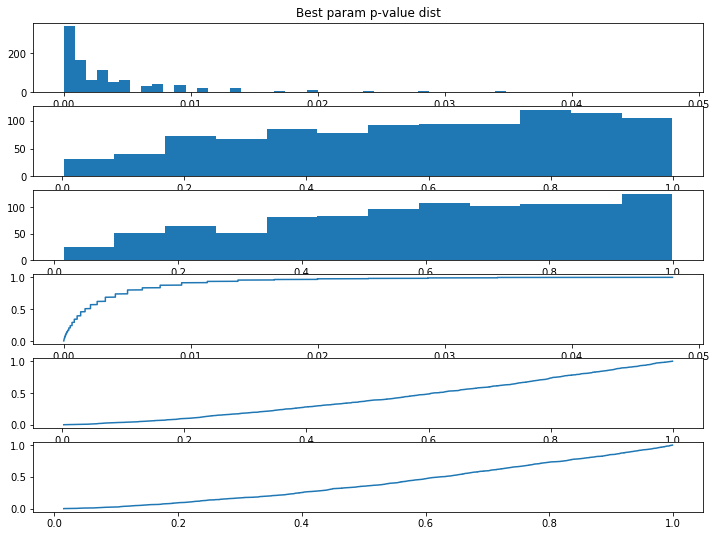

In [180]:
f, axarr = plt.subplots(6, figsize=(12, 9))
axarr[0].hist(p_vals_ks, bins='auto')
axarr[0].set_title('Best param p-value dist')
axarr[1].hist(p_vals_mwu, bins='auto')
axarr[2].hist(p_vals_w, bins='auto')
ks = np.sort(p_vals_ks)
mwu = np.sort(p_vals_mwu)
w = np.sort(p_vals_w)
prob = np.linspace(0, 1, len(p_vals_w))
axarr[3].plot(ks, prob)
axarr[4].plot(mwu, prob)
axarr[5].plot(w, prob)
plt.show()

In [97]:
#processing first wilcoxon test
greatest = 0.0
for params, arr in results.items():
    if arr[1] > greatest:
        greatest = arr[1]
        greatest_params = params
print(greatest, greatest_params)

0.962880246477 [ 0.     0.575  0.04   0.03   0.025]


In [77]:
#from old kstest
for arr in results.values():
    print(np.mean(arr))

1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6610651294e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.66250902

1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6610651294e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.6625090275e-242
1.66250902

1.62063598266e-242
1.62641157505e-242
1.64807004652e-242
1.6610651294e-242
1.6625090275e-242
1.6610651294e-242
1.6610651294e-242
1.62785547315e-242
1.65528953701e-242
1.6625090275e-242
1.65528953701e-242
1.65962123131e-242
1.59175802069e-242
1.63363106554e-242
1.63796275983e-242
1.64518225033e-242
1.64229445413e-242
1.51667531959e-242
1.59753361309e-242
1.60764089977e-242
1.63363106554e-242
1.63651886174e-242
1.41415855463e-242
1.54699717965e-242
1.59897751119e-242
1.61774818646e-242
1.62207988076e-242
1.61486039026e-242
1.64229445413e-242
1.65528953701e-242
1.65817733321e-242
1.65962123131e-242
1.54988497585e-242
1.61630428836e-242
1.65384563891e-242
1.65095784272e-242
1.64951394462e-242
1.52822650438e-242
1.5859824283e-242
1.63363106554e-242
1.62496767695e-242
1.64373835223e-242
1.46180719186e-242
1.55710446634e-242
1.5903141226e-242
1.59320191879e-242
1.61774818646e-242
1.39105618506e-242
1.5137875234e-242
1.55566056824e-242
1.60475310358e-242
1.5874263264e-242
1.53400209677e-242
1.

1.61919208456e-242
1.62785547315e-242
1.63363106554e-242
1.22356400568e-242
1.47480227475e-242
1.55421667014e-242
1.55566056824e-242
1.60475310358e-242
1.19324214561e-242
1.39971957365e-242
1.49501684812e-242
1.51523142149e-242
1.5859824283e-242
1.16003248936e-242
1.33763195543e-242
1.42570973941e-242
1.52389481008e-242
1.55854836444e-242
1.38961228696e-242
1.55421667014e-242
1.61052869597e-242
1.62929937125e-242
1.62785547315e-242
1.28853942009e-242
1.49212905192e-242
1.57731903971e-242
1.60186530738e-242
1.61052869597e-242
1.25099806954e-242
1.41704635082e-242
1.52822650438e-242
1.56865565113e-242
1.58020683591e-242
1.19179824752e-242
1.36506601929e-242
1.49790464432e-242
1.52822650438e-242
1.56576785493e-242
1.1311545274e-242
1.33907585352e-242
1.42859753561e-242
1.46036329377e-242
1.51523142149e-242
1.23800298666e-242
1.47480227475e-242
1.55710446634e-242
1.57154344732e-242
1.61774818646e-242
1.26688094862e-242
1.44736821088e-242
1.50512413481e-242
1.53255819867e-242
1.5888702245e-

In [86]:
#to save results dictionary REMEMBER TO RENAME
pickle.dump(results, open(".p", "wb"))
#to read back in
#arr = pickle.load( open( "kstest_5param_5.p", "rb" ) )